# Homework 1
## Introduction
### Important dates
* Homework release: Thursday, 3rd October 2019
* **Homework due**: Wednesday, 16th October 2019 (23:59 hours, 11:59 PM)
* Peer review due: Wednesday, 23rd October 2019 (23:59 hours, 11:59 PM)
* Grading release: Wednesday, 30th October 2019

### Description

The data you'll be working with comes from multiple sources. The main data source will be [DBLP](https://dblp.uni-trier.de/), a database of publications from major computer science journals and conferences. A subset of DBLP, which you will use in this assignment, is provided to you via a [google drive folder](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view). Later on, you will enrich the DBLP data with a dataset on conference rankings and with the proceedings of the [NIPS conference](https://nips.cc/) [1] ('proceedings' is another word for the set of papers published at an academic conference). After loading and cleaning the data, you will answer various questions about its contents.

**Some rules:**
- You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you have to justify your choice.
- Make sure you use the data folder provided in the repository in *read-only* mode.
- Be sure to provide explanations for your answers. A notebook that only has code cells will not suffice.
- Also, be sure to *hand in a fully-run and evaluated notebook*. We will not run your notebook for you, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

[1] Note that NIPS was renamed to NeurIPS in 2018, but for simplicity, whenever we say 'NIPS', we really mean 'NIPS and NeurIPS'.

## Task A. Getting a sense of the dataset

### A1. Loading the data
Download the DBLP dataset (available on [google drive](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view)) and load it into a Pandas dataframe. A row of your dataframe should look as follows:

| paper id | author names | publication year | paper title | 
| :----:|:-------------:| :-----:|:-----:|
| conf/nips/doe1036 | [John Doe, Jane Doe] | 2003 | Some Catchy Title: An Expanded and Boring Title | 


1. Filter the papers: keep only conference papers. For each of the remaining ones, find the acronym of the conference where it was published. Retain only those papers that have been published in the conferences listed in `data/list_of_ai_conferences.txt`. Additionally, add a column named 'conference' to your dataframe.   
_Hint: The `paper id` tells you whether a paper was published at a conference, and if so, at which one._

2. Report the overall number of papers in the filtered dataset, as well as the number of papers per conference.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup

#### Datafile analysis
We have analysed the raw data file. We have looked at the structure of the first multiple lines. We have observed, that the first row is a header followed by the data. We have observed that the first column is id, we have checked, if it's value is unique in the dataset. We have found out that it's and therefore can be used as an index in the pandas DataFrame. We have loaded the dblp.tsv into a DataFrame with new names of the columns and the id as an index. We have analysed the structure of the list_of_ai_conferences.txt and loaded it into a DataFrame.

In [2]:
# look ad the first 5 rows of hte dblp.tsv
! head -n 5 ./data/dblp.tsv

id	authors	year	title
tr/meltdown/s18	['Paul Kocher', 'Daniel Genkin', 'Daniel Gruss', 'Werner Haas', 'Mike Hamburg', 'Moritz Lipp', 'Stefan Mangard', 'Thomas Prescher 0002', 'Michael Schwarz 0001', 'Yuval Yarom']	2018.0	Spectre Attacks: Exploiting Speculative Execution.
tr/meltdown/m18	['Moritz Lipp', 'Michael Schwarz 0001', 'Daniel Gruss', 'Thomas Prescher 0002', 'Werner Haas', 'Stefan Mangard', 'Paul Kocher', 'Daniel Genkin', 'Yuval Yarom', 'Mike Hamburg']	2018.0	Meltdown
tr/acm/CS2013	[]	2013.0	Computer Science Curricula 2013
tr/gte/TR-0263-08-94-165	['Frank Manola']	1994.0	An Evaluation of Object-Oriented DBMS Developments: 1994 Edition.


In [3]:
# compute number of papers (except the first line because it's the header) in the dblp.tsv
! echo "Number of all papers ids:"
! tail -n+2 ./data/dblp.tsv | awk '{print $1}' | wc -l

Number of all papers ids:
4476041


In [4]:
# compute number of unique paper ids in the dblp.tsv 
! echo "Number of all unique papers ids:"
! tail -n+2 ./data/dblp.tsv | awk '{print $1}' | sort | uniq -c |  wc -l

Number of all unique papers ids:
4476041


In [109]:
# Load original dblp file and conference text file
papers_raw = pd.read_csv("./data/dblp.tsv",
                   sep='\t',
                   names=["paper id", "author names", "publication year", "paper title"],
                   index_col=0,
                   skiprows=1)

ai_conferences = pd.read_csv("./data/list_of_ai_conferences.txt", names=["conference name"], index_col=0)

In [110]:
papers_raw.head()

,author names,publication year,paper title
paper id,,,
tr/meltdown/s18,"['Paul Kocher', 'Daniel Genkin', 'Daniel Gruss...",2018.0,Spectre Attacks: Exploiting Speculative Execut...
tr/meltdown/m18,"['Moritz Lipp', 'Michael Schwarz 0001', 'Danie...",2018.0,Meltdown
tr/acm/CS2013,[],2013.0,Computer Science Curricula 2013
tr/gte/TR-0263-08-94-165,['Frank Manola'],1994.0,An Evaluation of Object-Oriented DBMS Developm...
tr/gte/TR-0222-10-92-165,"['Michael L. Brodie', 'Michael Stonebraker']",1993.0,DARWIN: On the Incremental Migration of Legacy...


In [111]:
ai_conferences

""
conference name
cvpr
icra
iccv
icml
nips
acl
emnlp
aaai
aamas


In [112]:
# filter out those published in the conferences and add a new column specifying their conference name
papers_in_conf = papers_raw[papers_raw.index.map(lambda id: True if (id.split('/')[1] in ai_conferences.index) & (id.split('/')[0] == 'conf') else False)]
conf_names = papers_in_conf.index.to_series().map(lambda id: id.split('/')[1])
papers_in_conf = pd.concat([papers_in_conf, conf_names], axis = 1).rename(columns = {'paper id': 'conference'})
papers_in_conf.head()

,author names,publication year,paper title,conference
paper id,,,,
conf/iccv/KunoOO90,"['Yoshinori Kuno', 'Yasukazu Okamoto', 'Satosh...",1990.0,Object recognition using a feature search stra...,iccv
conf/iccv/VedulaBRCK99,"['Sundar Vedula', 'Simon Baker', 'Peter Rander...",1999.0,Three-Dimensional Scene Flow.,iccv
conf/iccv/MeminP99,"['Étienne Mémin', 'Patrick Pérez']",1999.0,Fluid Motion Recovery by Coupling Dense and Pa...,iccv
conf/iccv/DickinsonPR90,"['Sven J. Dickinson', 'Alex Pentland', 'Azriel...",1990.0,Qualitative 3-D shape reconstruction using dis...,iccv
conf/iccv/SinghYL17,"['Avi Singh', 'Larry Yang', 'Sergey Levine']",2017.0,GPLAC: Generalizing Vision-Based Robotic Skill...,iccv


In [113]:
# Total number of filtered dataset
print('Total number of filtered dataset: {0}'.format(len(papers_in_conf)))

Total number of filtered dataset: 102003


In [114]:
# Number of papers per conference
print('Number of papers per conference: \n')
print(pd.DataFrame(papers_in_conf.groupby('conference').size().rename('Number')))

Number of papers per conference: 

            Number
conference        
aaai         10796
aamas          367
accv          2390
acl           6330
cvpr         12853
emnlp         3299
fgr           1383
icann         3134
iccbr          863
iccv          4179
icml          5017
iconip        4985
icra         21585
ida            712
ijcai         9669
ilp            679
ksem           635
naacl         3310
nips          8445
pricai        1372


### A2. An author-centric look
The dataframe you created above was a paper-centric one. Now, we want you to create a new dataframe centered around authors. Do this by expanding the author names in the lists in the 2nd column into separate rows. That is, if a paper has 3 authors, turn that row into 3 rows, each of which only contains one of the author names (along with the rest of the paper information, i.e., title, conference and year). Keep both dataframes, we are going to need both of them.    
**Report the number of unique authors.**

In [115]:
# Create a author-centric dataframe
authors_in_conf = (papers_in_conf['author names']
                  .apply(lambda x: x.strip('[]').replace('\'', '').split(', ')).apply(pd.Series)
                  .merge(papers_in_conf, left_index = True, right_index = True)
                  .drop(['author names'], axis = 1).reset_index()
                  .melt(id_vars = ['paper id', 'publication year', 'paper title', 'conference'], value_name = 'author')
                  .drop('variable', axis = 1)
                  .dropna(subset = ['author']))

authors_in_conf['author'] = authors_in_conf['author'].str.strip('/"')
# authors_in_conf['author'] = authors_in_conf['author'].apply(lambda name: re.sub('\d+', "", name) if re.search('\d', name) else name)
authors_in_conf.head()

,paper id,publication year,paper title,conference,author
0,conf/iccv/KunoOO90,1990.0,Object recognition using a feature search stra...,iccv,Yoshinori Kuno
1,conf/iccv/VedulaBRCK99,1999.0,Three-Dimensional Scene Flow.,iccv,Sundar Vedula
2,conf/iccv/MeminP99,1999.0,Fluid Motion Recovery by Coupling Dense and Pa...,iccv,Étienne Mémin
3,conf/iccv/DickinsonPR90,1990.0,Qualitative 3-D shape reconstruction using dis...,iccv,Sven J. Dickinson
4,conf/iccv/SinghYL17,2017.0,GPLAC: Generalizing Vision-Based Robotic Skill...,iccv,Avi Singh


In [116]:
# Number of unique authors
print('Total number of unique authors: {0}'.format(len(authors_in_conf['author'].unique())))

Total number of unique authors: 105815


### A3. Is your data analysis-friendly?

Using an appropriate view of your data (paper-centric or author-centric), solve the following tasks:

1. Plot the number of papers per author and analyze it. Do you observe any outliers? Can you identify the source of the problem? Please elaborate!   
_Hint: To find out where the problem comes from, try performing an analysis at the conference or year level._   
Make sure you remove this inconsistency from your dataframe before moving to the next step, and also create a new plot of the number of papers per author after fixing the problem.   

2. Plot the number of papers per year. Do you observe any inconsistency in the output? Real-world data is usually messy, with typos, erroneous entries, and sometimes issues that make even loading the data problematic. Fix any errors that you encounter along the way, find ways to clean the attribute `year`, and redo the plot of the number of papers per year.   

3. Machine learning (ML) has been one of the hottest topics within the broader area of AI recently, so let’s see if this is reflected in the number of ML publications. In particular, let’s focus on the two major ML conferences, NIPS and ICML: make a new dataframe with only NIPS and ICML papers (let’s call these the “ML papers”), plot the number of ML papers over time, and analyze and discuss the plot. Do you observe anything odd in this plot? What causes these problems?   
_Hint: Try to perform an analysis at the conference or year level._   

4. By now, you may have noticed that some conferences are not fully represented in the DBLP dataset. Complete the paper-centric dataframe by scraping the full NIPS data from the online proceedings at https://papers.nips.cc/ (maintain the same schema used in your previous dataframes, but fill in missing values). After this step, remove any remaining papers that have missing values. Redo the plots of steps A3.2 and A3.3 after fixing the issue.   

_Note: In order to avoid re-running the cleaning part of the notebook every time, you could save the results at this point as a pickle file! Also, propagating your cleaning to both dataframes might prove useful later on._

***A3.1***

#### Calculate the paper number for each author and plot the distribution to see if there is any outlier

In [117]:
# show the number of papers per author
num_paper_per_author = (authors_in_conf
                        .groupby('author')['paper id']
                        .count()
                        .reset_index()
                        .rename(columns = {'paper id': 'counts'}))

num_paper_per_author.sort_values(by = ['counts'], ascending = False).reset_index().drop(['index'], axis = 1).head()

,author,counts
0,,950
1,Sheila A. McIlraith,918
2,Satinder P. Singh (ed.),663
3,Luc Van Gool,220
4,Toshio Fukuda,196


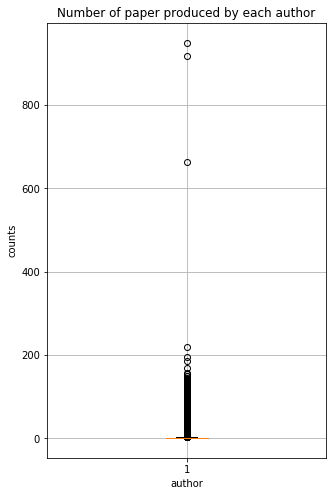

In [118]:
# plot the figure
plt.figure(figsize = (5, 8))
plt.boxplot(num_paper_per_author['counts'])
plt.grid()
plt.xlabel('author')
plt.ylabel('counts')
plt.title('Number of paper produced by each author')
plt.show()

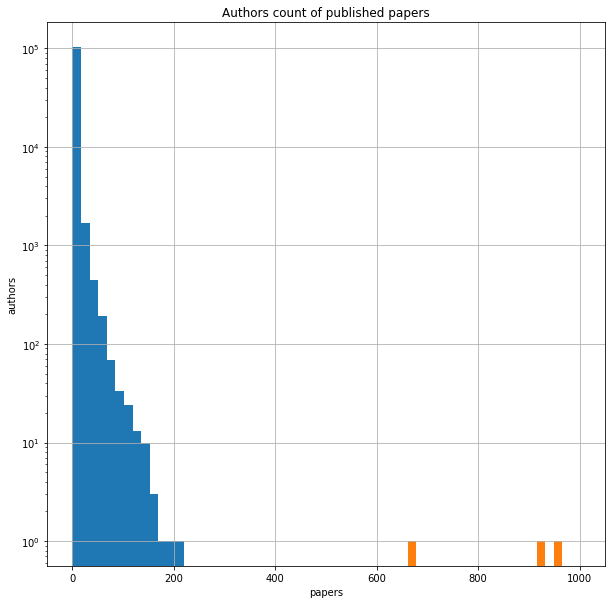

In [119]:
# Plot histogram of authors count of published papers
plt.figure(figsize = (10, 10))

bins_ = np.linspace(0, 1000, 60)
plt.hist(num_paper_per_author[num_paper_per_author['counts'] < 600]['counts'], bins=bins_)
plt.hist(num_paper_per_author[num_paper_per_author['counts'] > 600]['counts'], bins=bins_)
plt.gca().set_yscale('log')
plt.grid()
plt.title('Authors count of published papers')
plt.xlabel('papers')
plt.ylabel('authors')
plt.show()

#### Explanation:
1. From the plot above, we can easily see that there are 3 outliers: empty value,  Sheila A. McIlraith, and Satinder P. Singh (ed.). That being said, these 3 authors have more papers published than any other authors in the given dataset. Below we will check further about their publication distribution in conferences.

#### Investigate more about three suspicious outliers papers distribution in every conference and year

In [120]:
# Take a look at three possible outliers' number of papers in respective conferences and the number of papers per year.
num_paper_per_author_per_conf = (authors_in_conf
                                .groupby(['author', 'conference'])['paper id']
                                .count()
                                .reset_index()
                                .rename(columns = {'paper id': 'counts'}))

num_paper_per_author_per_year = (authors_in_conf
                                .groupby(['author', 'publication year'])['paper id']
                                .count()
                                .reset_index()
                                .rename(columns = {'paper id': 'counts'}))

print('Empty Value \n')
print(num_paper_per_author_per_conf[num_paper_per_author_per_conf.author == ''].sort_values(by = 'counts', ascending = False).reset_index().drop(['index'], axis = 1).head(3))
print(num_paper_per_author_per_year[num_paper_per_author_per_year.author == ''].sort_values(by = 'counts', ascending = False).reset_index().drop(['index'], axis = 1).head(3))
print('\n\nSheila A. McIlraith \n')
print(num_paper_per_author_per_conf[num_paper_per_author_per_conf.author == 'Sheila A. McIlraith'].sort_values(by = 'counts', ascending = False).reset_index().drop(['index'], axis = 1).head(3))
print(num_paper_per_author_per_year[num_paper_per_author_per_year.author == 'Sheila A. McIlraith'].sort_values(by = 'counts', ascending = False).reset_index().drop(['index'], axis = 1).head(3))
print('\n\n Satinder P. Singh (ed.)    \n')
print(num_paper_per_author_per_conf[num_paper_per_author_per_conf.author == 'Satinder P. Singh (ed.)'].sort_values(by = 'counts', ascending = False).reset_index().drop(['index'], axis = 1).head(3))
print(num_paper_per_author_per_year[num_paper_per_author_per_year.author == 'Satinder P. Singh (ed.)'].sort_values(by = 'counts', ascending = False).reset_index().drop(['index'], axis = 1).head(3))

Empty Value 

  author conference  counts
0               acl     140
1             ijcai     122
2              aaai     108
  author publication year  counts
0                  2016.0      55
1                  2015.0      51
2                  2011.0      49


Sheila A. McIlraith 

                author conference  counts
0  Sheila A. McIlraith       aaai     904
1  Sheila A. McIlraith      ijcai      13
2  Sheila A. McIlraith       icml       1
                author publication year  counts
0  Sheila A. McIlraith           2018.0     893
1  Sheila A. McIlraith           2016.0       3
2  Sheila A. McIlraith           2007.0       2


 Satinder P. Singh (ed.)    

                    author conference  counts
0  Satinder P. Singh (ed.)       aaai     663
                    author publication year  counts
0  Satinder P. Singh (ed.)           2017.0     663


In [18]:
# Check Sheila A. McIlraith's papers for aaai coference in 2018
# Also check Sheila A. McIlraith's papers in conferences other than aaai and papers in aaai conferences before 2018

print('The papers published by Sheila A. McIlraith for aaai in 2018 do not contain her initial in the id')
display(authors_in_conf[(authors_in_conf['author'] == 'Sheila A. McIlraith') & (authors_in_conf['conference'] == 'aaai') & (authors_in_conf['publication year'] == '2018.0')][['paper id','publication year','conference']].head())
print('\nThe papers published by Sheila A. McIlraith for other conferences seem to contains her initial in the id')
display(authors_in_conf[(authors_in_conf['author'] == 'Sheila A. McIlraith') & ~(authors_in_conf['conference'] == 'aaai')][['paper id','publication year','conference']].head())
print('\nThe papers published by Sheila A. McIlraith for aaai seems before 2017 seem to contains her initial in the id')
display(authors_in_conf[(authors_in_conf['author'] == 'Sheila A. McIlraith') & (authors_in_conf['conference'] == 'aaai') & ~(authors_in_conf['publication year'] == '2018.0')][['paper id','publication year','conference']].head())

The papers published by Sheila A. McIlraith for aaai in 2018 do not contain her initial in the id


,paper id,publication year,conference
34101,conf/aaai/2018w,2018.0,aaai
38936,conf/aaai/2018,2018.0,aaai
134324,conf/aaai/Lorini18,2018.0,aaai
134419,conf/aaai/Abhishek18,2018.0,aaai
134513,conf/aaai/Heule18,2018.0,aaai



The papers published by Sheila A. McIlraith for other conferences seem to contains her initial in the id


,paper id,publication year,conference
81449,conf/ijcai/McIlraithA01,<i>2001.0</i>,ijcai
183371,conf/ijcai/MuiseMB11,2011.0,ijcai
187370,conf/ijcai/MacCartneyMAU03,2003.0,ijcai
187640,conf/ijcai/IllanesM16,<i>2016.0</i>,ijcai
188013,conf/ijcai/IllanesM17,'17,ijcai



The papers published by Sheila A. McIlraith for aaai seems before 2017 seem to contains her initial in the id


,paper id,publication year,conference
35347,conf/aaai/McIlraithS00,'00,aaai
35462,conf/aaai/McIlraith97,<em>1997.0</em>,aaai
139468,conf/aaai/BaierM06,2006.0,aaai
140760,conf/aaai/RobinsonMT14,2014.0,aaai
144926,conf/aaai/MuiseMBH10,2010.0,aaai


In [122]:
# Check Satinder P. Singh (ed.)'s papers
authors_in_conf[(authors_in_conf['author'] == 'Satinder P. Singh (ed.)') & (authors_in_conf['conference'] == 'aaai') & (authors_in_conf['publication year'] == '2017.0')].head()

,paper id,publication year,paper title,conference,author
36976,conf/aaai/2017,2017.0,Proceedings of the Thirty-First AAAI Conferenc...,aaai,Satinder P. Singh (ed.)
38242,conf/aaai/2017w,2017.0,The Workshops of the The Thirty-First AAAI Con...,aaai,Satinder P. Singh (ed.)
134421,conf/aaai/Luger17,2017.0,Beyond Mechanical Turk: Using Techniques from ...,aaai,Satinder P. Singh (ed.)
134437,conf/aaai/Beckers17,2017.0,AAAI: An Argument Against Artificial Intellige...,aaai,Satinder P. Singh (ed.)
134490,conf/aaai/Sheh17,2017.0,"""Why Did You Do That?"" Explainable Intelligent...",aaai,Satinder P. Singh (ed.)


#### Explanation:
The paper id in the dataframe consists of three parts: 1. character "conf", 2. conference name, 3. Surname of 1st author + Initial of 2nd or more authors' surname + year.
Looking into the paper id of papers published by Sheila A. MacIlaith for aaai in 2018 and by Satiner P. Singh (ed.) in 2017, we find out that these id does not include their initials. By contrast, for papers published by Sheila A. MacIlaith for other conferences than aaai or for aaai before 2017, corresponding paper id seems to include her initial. 
The data on dblp (Sheila A. McIlraith and Satinder P. Singh) tells us that Sheila A, McIlraith did not published paper for aaai in 2018 but she published several papers for other conferences in 2018 and for aaai before 2017 and Satinder P. Singh neither published any paper in 2017. Regarding aaai conferences he worked only as an editor in 2017.
So we remove following outliers from dataframe.

- Sheila A, McIlraith's papers for aaai published in 2018
- Satinder P. Singh's papers in 2017
- Papers with no author

#### Remove outliers from thr original dataframe and make a new plot to check the distribution without outliers

In [20]:
# Remove outliers
authors_in_conf = authors_in_conf[~(authors_in_conf['author'] == 'Sheila A. McIlraith') &
                                  ~(authors_in_conf['conference'] == 'aaai') &
                                  ~(authors_in_conf['publication year'] == '2018.0')]
authors_in_conf = authors_in_conf[~authors_in_conf['author'].isin(['', 'Satinder P. Singh (ed.)'])]

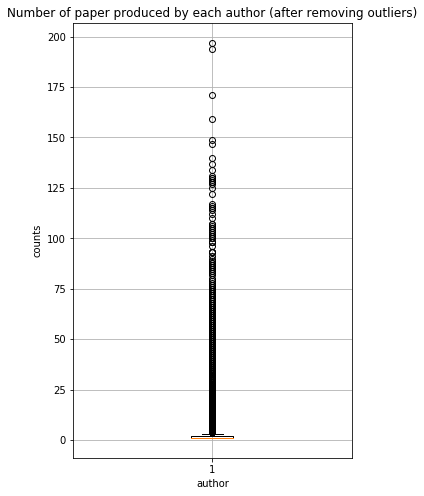

In [21]:
# Create a new plot showing the number of papers per author
num_paper_per_author = (authors_in_conf
                        .groupby('author')['paper id']
                        .count()
                        .reset_index()
                        .rename(columns = {'paper id': 'counts'}))

num_paper_per_author.sort_values(by = ['counts'], ascending = False).reset_index().drop(['index'], axis = 1)

# # plot the figure (change to histogram or keep boxplot)
plt.figure(figsize = (5, 8))
plt.boxplot(num_paper_per_author['counts'])
plt.grid()
plt.xlabel('author')
plt.ylabel('counts')
plt.title('Number of paper produced by each author (after removing outliers)')
plt.show()

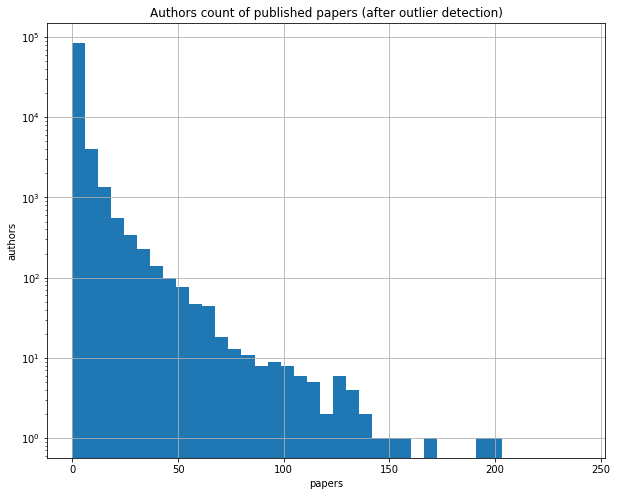

In [22]:
# Create a new plot showing activity of the authors
num_paper_per_author = (authors_in_conf
                        .groupby('author')['paper id']
                        .count()
                        .reset_index()
                        .rename(columns = {'paper id': 'counts'}))

plt.figure(figsize = (10, 8))
bins_ = np.linspace(0, 240, 40)
plt.hist(num_paper_per_author['counts'], bins=bins_)
plt.gca().set_yscale('log')
plt.grid()
plt.title('Authors count of published papers (after outlier detection)')
plt.xlabel('papers')
plt.ylabel('authors')
plt.show()

***A3.2***

#### First, without any processing and cleaning, we make a plot to view number of papers every year. Then, after finding varied formats of years, we arrange an unified format for years.

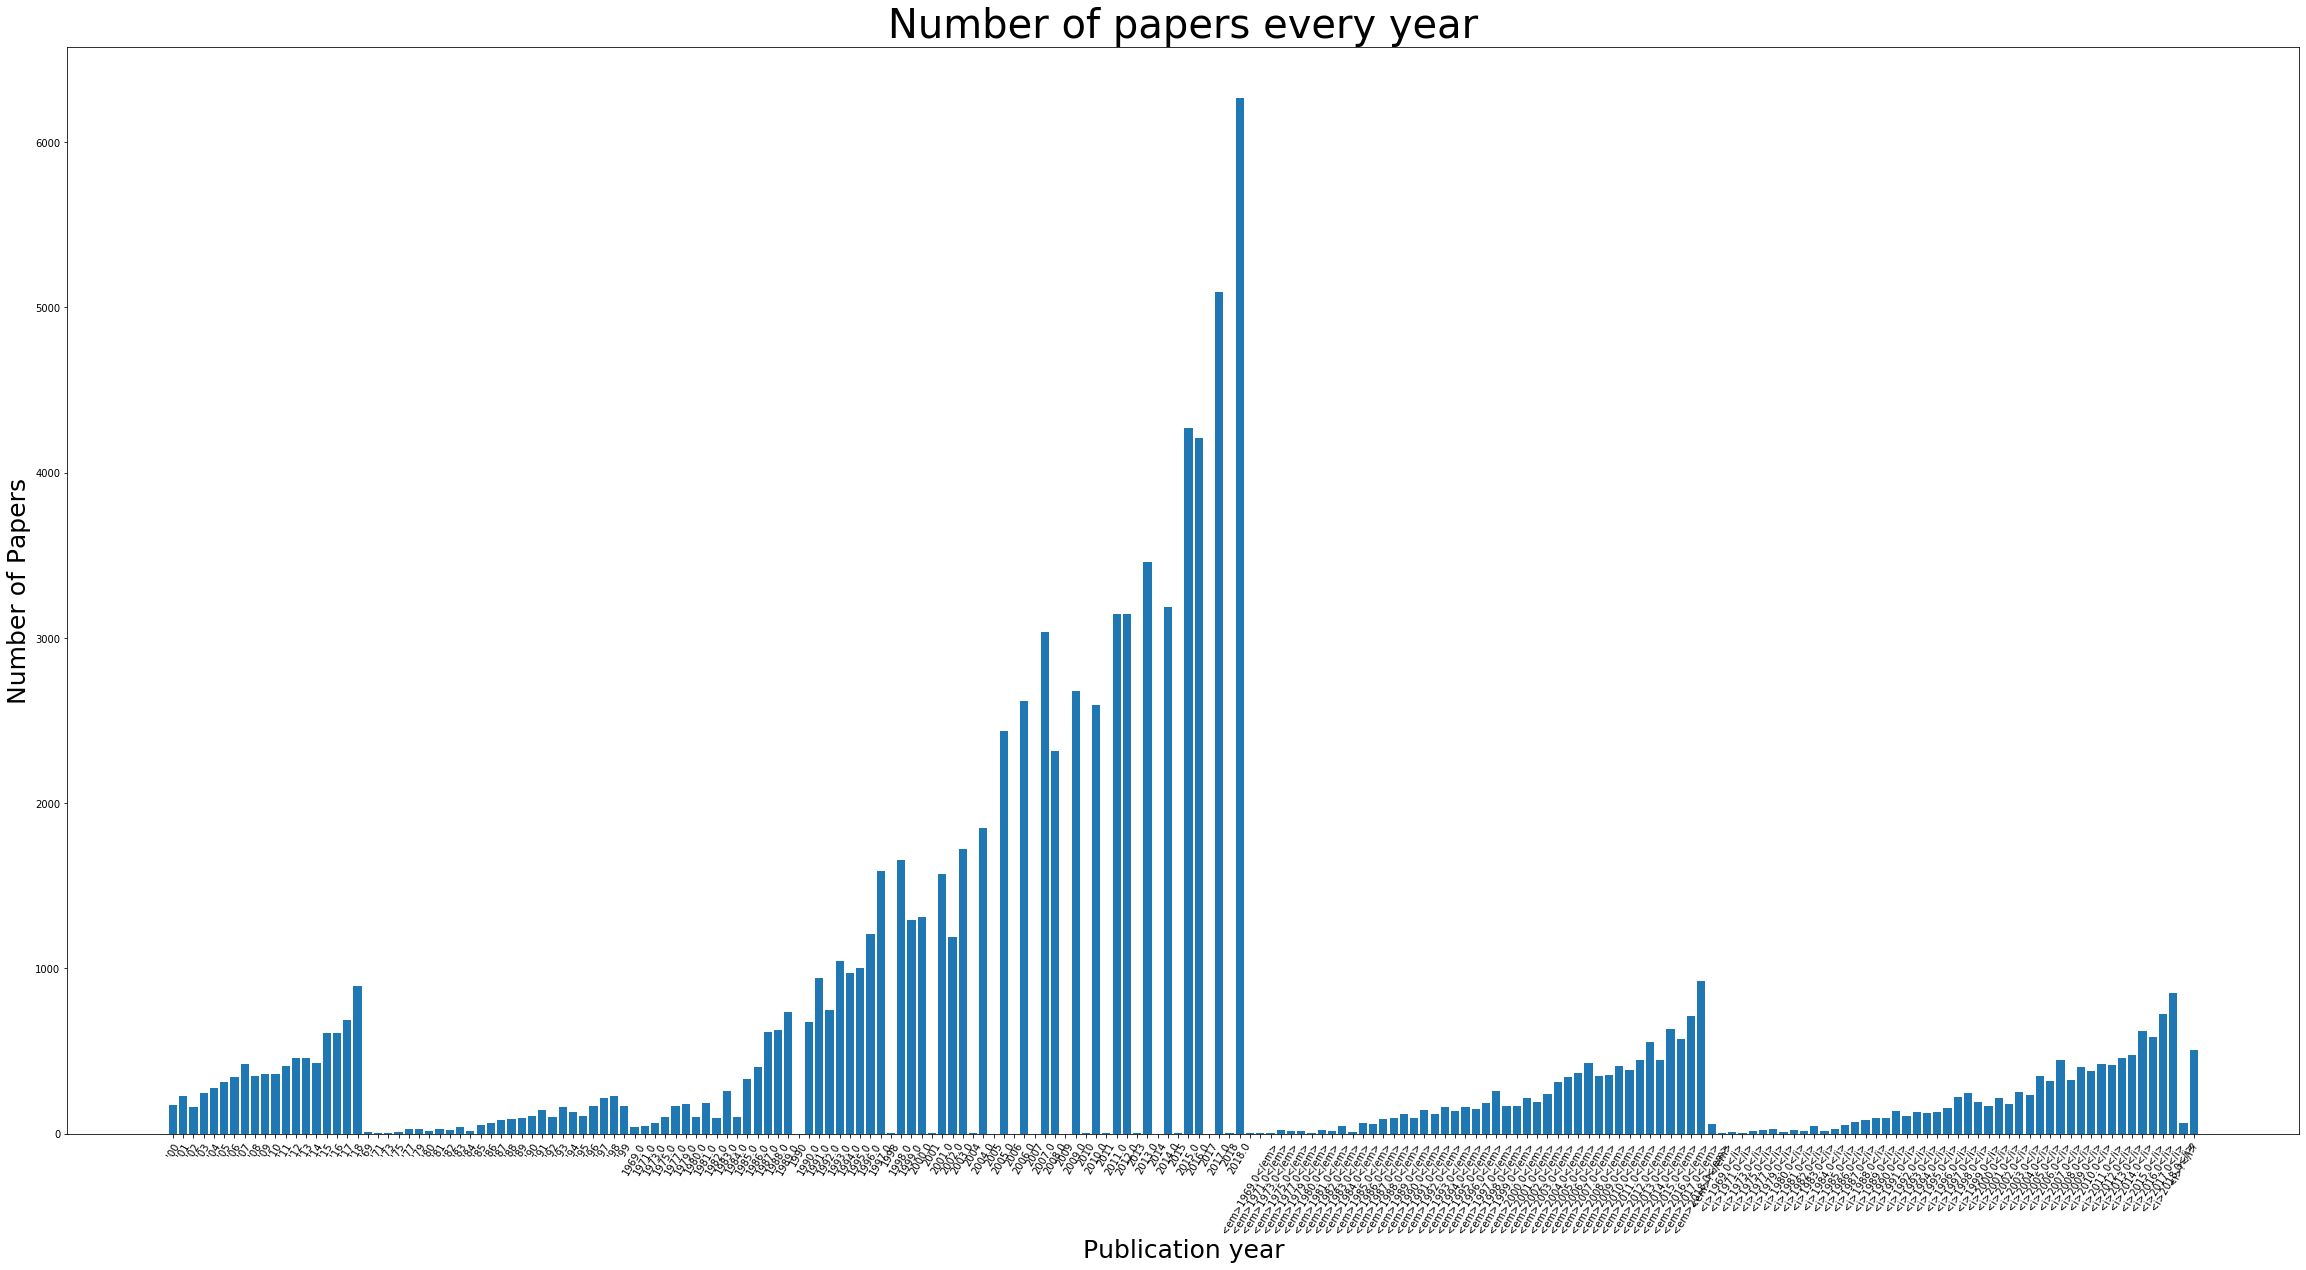

In [23]:
# plot of uncleaned data
num_paper_per_year = ((papers_in_conf.reset_index())
                     .groupby('publication year')['paper id']
                     .count()
                     .reset_index()
                     .rename(columns = {'paper id': 'counts'}))

plt.figure(figsize=(40, 20))
plt.bar(num_paper_per_year['publication year'], num_paper_per_year['counts'])
plt.xticks(rotation=60)
plt.xlabel('Publication year', fontsize= 25)
plt.ylabel('Number of Papers', fontsize = 25)
plt.title('Number of papers every year', fontsize = 40)
plt.show()

#### Explanation:
1. Before cleaning, data in the column of year vary a lot. A lot of different year formats exist in our given dataset. Thus, it is needed to arrange the same format for all of the year data inside the dataset.  

In [24]:
# Clean the data format in the column, "publication year"

# A function recognizes a possible year when the paper is published
def year_recog(year):
    if year[0] == '\'':
        year = year[1:]
        if int(year) < 19:
            return "20"+year
        else:
            return "19"+year
    else:
        return year

# Get rid of unrelevant string components in the column, 'publication year'
authors_in_conf['publication year'] = (authors_in_conf['publication year']
                                       .str.lstrip('<i><em>')
                                       .str.rstrip('</i></em>')
                                       .apply(year_recog)
                                       .apply(lambda year: year[:4] if year != '?' else year))

papers_in_conf['publication year'] = (papers_in_conf['publication year']
                                       .str.lstrip('<i><em>')
                                       .str.rstrip('</i></em>')
                                       .apply(year_recog)
                                       .apply(lambda year: year[:4] if year != '?' else year))


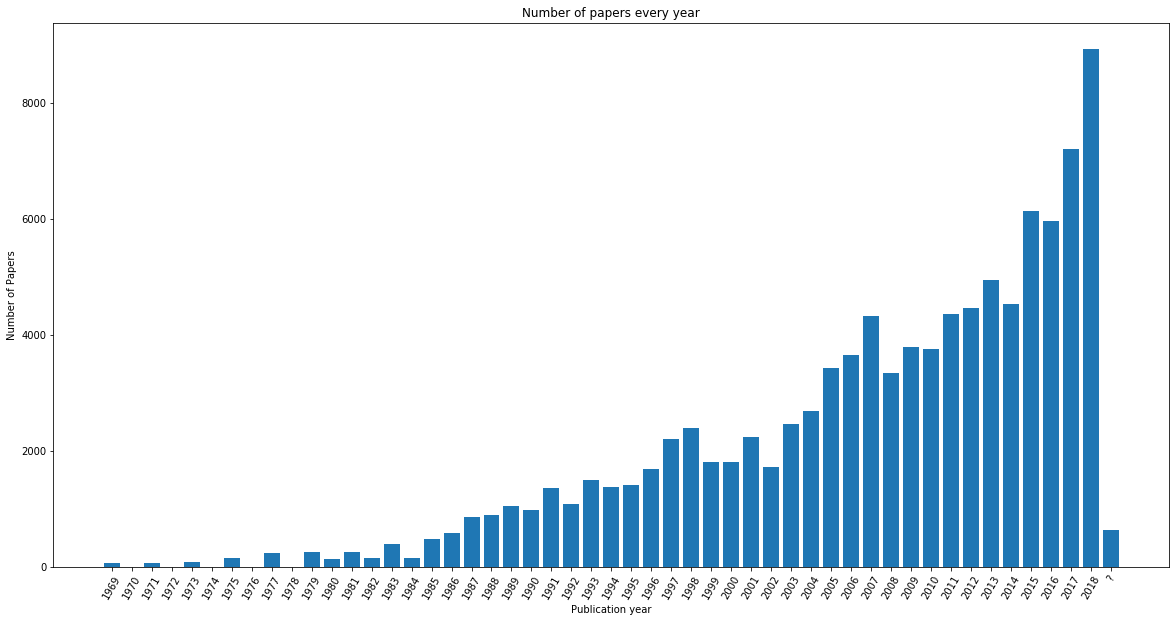

In [25]:
# Plot the number of papers per year

num_paper_per_year = ((papers_in_conf.reset_index())
                     .groupby('publication year')['paper id']
                     .count()
                     .reset_index()
                     .rename(columns = {'paper id': 'counts'}))

num_paper_per_year = num_paper_per_year.append(pd.DataFrame({'publication year': ['1970', '1972', '1974', '1976', '1978'], 
                                                             'counts': [0, 0, 0, 0, 0]}))
num_paper_per_year.sort_values('publication year', inplace=True)
num_paper_per_year = num_paper_per_year.reset_index().drop(columns=['index'])

plt.figure(figsize=(20, 10))
plt.bar(num_paper_per_year['publication year'], num_paper_per_year['counts'])
plt.xticks(rotation=60)
plt.xlabel('Publication year')
plt.ylabel('Number of Papers')
plt.title('Number of papers every year')
plt.show()

#### Explanation:
1. After cleaning, our visualization for number of papers every year becomes much clear and concise. However, there are still some missing year, marked with ?, we cannot resolve yet now.

***A3.3***

#### Select ML conferences, ICML and NIPS, to see its distribution

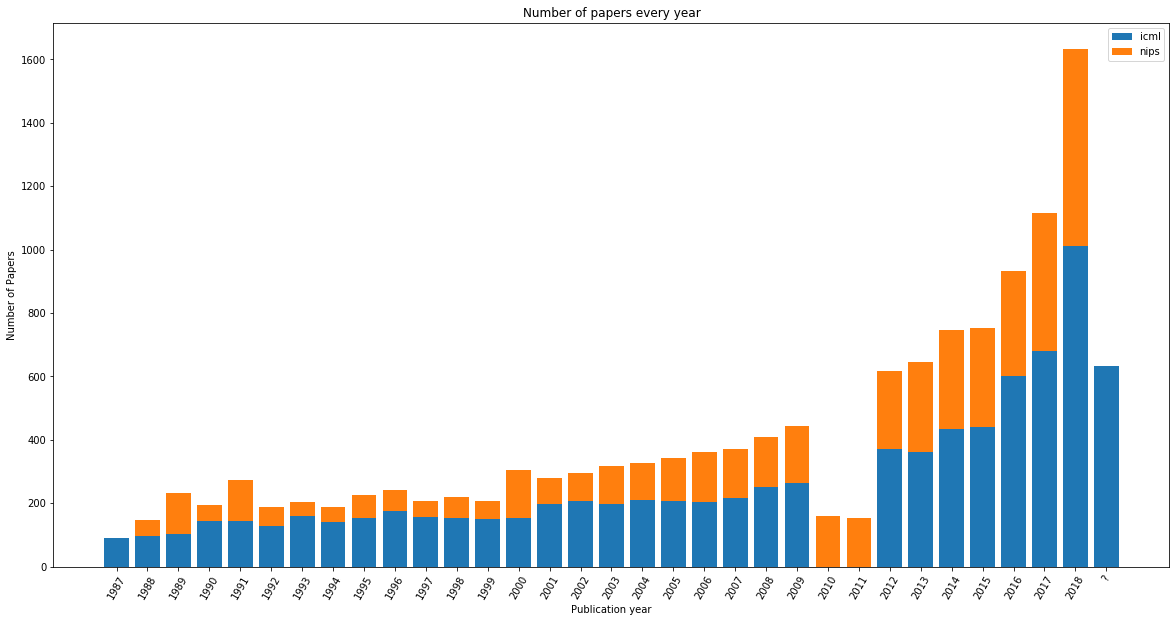

In [26]:
mlconf = ['icml', 'nips']

# Create a dataframe containing the papers published in ML conferences
mlpapers = papers_in_conf[papers_in_conf['conference'].isin(mlconf)]

# Count the pubblications per year
num_mlpaper_per_year = ((mlpapers.reset_index())
                        .groupby(['publication year', 'conference'])['paper id']
                        .count()
                        .reset_index()
                        .rename(columns = {'paper id': 'counts'}))

# Split into two dataframes, one per conference
nips_per_year = num_mlpaper_per_year[num_mlpaper_per_year['conference'] == 'nips'].reset_index().drop(columns=['index'])
icml_per_year = num_mlpaper_per_year[num_mlpaper_per_year['conference'] == 'icml'].reset_index().drop(columns=['index'])

# Add 1987 and '?' to icml (counts = 0)
icml_per_year = icml_per_year.append(pd.DataFrame({'publication year': ['1987'], 'conference': ['icml'], 'counts': [0]}))
icml_per_year = icml_per_year.append(pd.DataFrame({'publication year': ['?'], 'conference': ['icml'], 'counts': [0]}))
icml_per_year.sort_values('publication year', inplace=True)
icml_per_year = icml_per_year.reset_index().drop(columns=['index'])

# Add 2010 and 2011 to nips (counts = 0)
nips_per_year = nips_per_year.append(pd.DataFrame({'publication year': ['2010'], 'conference': ['nips'], 'counts': [0]}))
nips_per_year = nips_per_year.append(pd.DataFrame({'publication year': ['2011'], 'conference': ['nips'], 'counts': [0]}))
nips_per_year.sort_values('publication year', inplace=True)
nips_per_year = nips_per_year.reset_index().drop(columns=['index'])

# Stacked barplot
plt.figure(figsize=(20, 10))
plt.bar(nips_per_year['publication year'], nips_per_year['counts'])
plt.bar(icml_per_year['publication year'], icml_per_year['counts'], bottom=nips_per_year['counts'])
plt.legend(['icml', 'nips'])
plt.xticks(rotation=60)
plt.xlabel('Publication year')
plt.ylabel('Number of Papers')
plt.title('Number of papers every year')
plt.show()

#### Explanation:
1. From the plot, we can see that the trend grows almost exponentially. (Ignore the year with "?")
2. However, in 2010 and 2011, number of ML papers sharply drops, violating the trend we expect. Thus, we suspect that there are some missing value in the given dataset.

***A3.4***

In [27]:
# do web scraping from nips website to grasp paper title and corresponding year to dataframe (also need to add authors' name to update missing authors)
r = get('https://papers.nips.cc/')
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')
all_links = soup.find_all('a')
all_data = {'paper title': [], 'publication year':[]}

for link in all_links:
    paper_url = link.get('href')
    if paper_url.startswith('/book'):
        r_paper = get('https://papers.nips.cc/' + paper_url)
        soup_paper = BeautifulSoup(r_paper.text, 'html.parser')
        paper_a_tag = soup_paper.select('ul a')
        for a_tag in paper_a_tag:
            if a_tag['href'].startswith('/paper'):
                all_data['publication year'].append(soup_paper.title.text.split()[1])
                all_data['paper title'].append(a_tag.text)

all_data_df = pd.DataFrame(all_data)
all_data_df.head()

,paper title,publication year
0,Efficient Algorithms for Non-convex Isotonic R...,2018
1,Structure-Aware Convolutional Neural Networks,2018
2,Kalman Normalization: Normalizing Internal Rep...,2018
3,HOGWILD!-Gibbs can be PanAccurate,2018
4,Text-Adaptive Generative Adversarial Networks:...,2018


In [28]:
# remove punctuation in the paper titles for original paper-centric dataframe and web-scraped dataframe
papers_in_conf_comp = papers_in_conf.copy()
papers_in_conf_comp['paper title'] = (papers_in_conf_comp['paper title']
                                      .str.replace(r'[^\w\s]+', '')
                                      .str.normalize('NFKD')
                                      .str.encode('ascii', errors='ignore')
                                      .str.decode('utf-8'))
all_data_df['paper title'] = (all_data_df['paper title']
                              .str.replace(r'[^\w\s]+', '')
                              .str.normalize('NFKD')
                              .str.encode('ascii', errors='ignore')
                              .str.decode('utf-8'))

# fill in the year value that is missing in the original dataframe
for indx, row in papers_in_conf_comp.iterrows():
    if row['publication year'] == '?':
        paper_title = row['paper title'].replace(r'[^\w\s]+', '')
        if len(all_data_df.loc[all_data_df['paper title'] == paper_title, 'publication year'].values) != 0:
            year = all_data_df.loc[all_data_df['paper title'] == paper_title, 'publication year'].values[0]
            papers_in_conf_comp.at[indx, 'publication year'] = str(year)

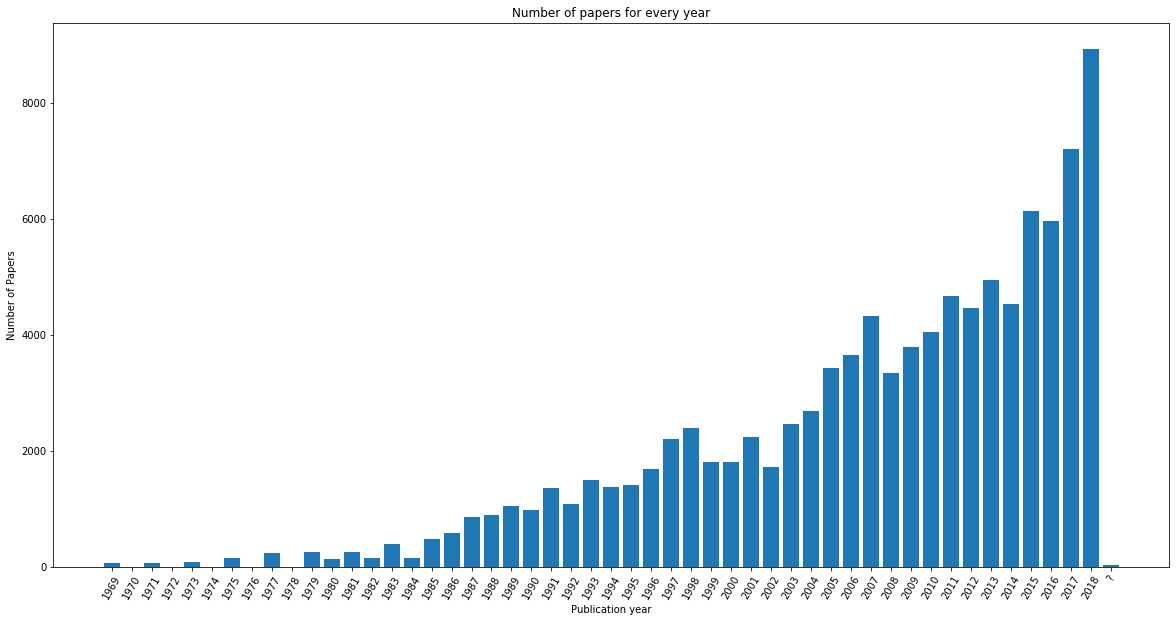

In [29]:
# Make a plot to see number of papers every year 
num_paper_per_year_comp = ((papers_in_conf_comp.reset_index())
                           .groupby('publication year')['paper id']
                           .count()
                           .reset_index()
                           .rename(columns = {'paper id': 'counts'}))

num_paper_per_year_comp = num_paper_per_year_comp.append(pd.DataFrame({'publication year': ['1970', '1972', '1974', '1976', '1978'], 
                                                             'counts': [0, 0, 0, 0, 0]}))
num_paper_per_year_comp.sort_values('publication year', inplace=True)
num_paper_per_year_comp = num_paper_per_year_comp.reset_index().drop(columns=['index'])
                             
plt.figure(figsize=(20, 10))
plt.bar(num_paper_per_year_comp['publication year'], num_paper_per_year_comp['counts'])
plt.xticks(rotation=60)
plt.xlabel('Publication year')
plt.ylabel('Number of Papers')
plt.title('Number of papers for every year')
plt.show()

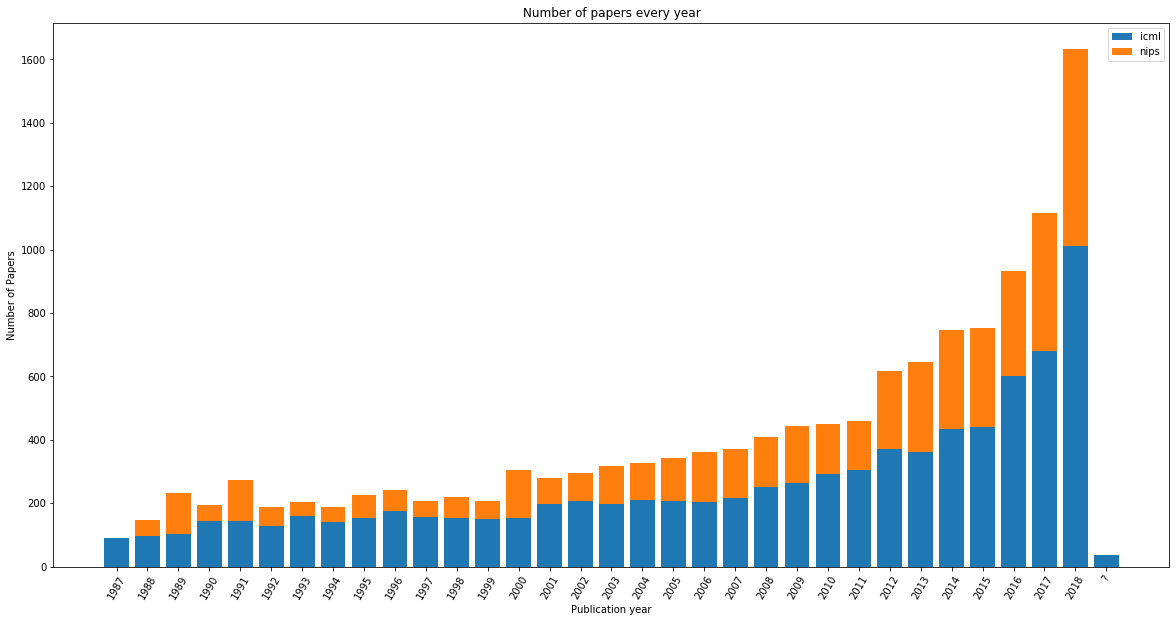

In [30]:
# Create a dataframe containing the papers published in ML conferences
mlpapers_comp = papers_in_conf_comp[papers_in_conf_comp['conference'].isin(mlconf)]

# Count the pubblications per year
num_mlpaper_per_year_comp = ((mlpapers_comp.reset_index())
                        .groupby(['publication year', 'conference'])['paper id']
                        .count()
                        .reset_index()
                        .rename(columns = {'paper id': 'counts'}))

# Split into two dataframes, one per conference
nips_per_year = num_mlpaper_per_year_comp[num_mlpaper_per_year_comp['conference'] == 'nips'].reset_index().drop(columns=['index'])
icml_per_year = num_mlpaper_per_year_comp[num_mlpaper_per_year_comp['conference'] == 'icml'].reset_index().drop(columns=['index'])

# Add 1987 and '?' to icml (counts = 0)
icml_per_year = icml_per_year.append(pd.DataFrame({'publication year': ['1987'], 'conference': ['icml'], 'counts': [0]}))
icml_per_year = icml_per_year.append(pd.DataFrame({'publication year': ['?'], 'conference': ['icml'], 'counts': [0]}))
icml_per_year.sort_values('publication year', inplace=True)
icml_per_year = icml_per_year.reset_index().drop(columns=['index'])

# Stacked barplot
plt.figure(figsize=(20, 10))
plt.bar(nips_per_year['publication year'], nips_per_year['counts'])
plt.bar(icml_per_year['publication year'], icml_per_year['counts'], bottom=nips_per_year['counts'])
plt.legend(['icml', 'nips'])
plt.xticks(rotation=60)
plt.xlabel('Publication year')
plt.ylabel('Number of Papers')
plt.title('Number of papers every year')
plt.show()

In [31]:
# remove any paper that still has missing value
papers_in_conf = papers_in_conf[papers_in_conf['publication year'] != '?']
authors_in_conf = authors_in_conf[authors_in_conf['publication year'] != '?']

### A4. Author activity

For each author, calculate their normalized paper count, defined as the total number of papers divided by the author’s period of activity. An author’s period of activity is defined as the number of years between the earliest and latest papers of this author. Plot the distribution of the normalized paper count. What is the appropriate scale for the axes? Does the distribution (roughly) follow a particular law, and if yes, which one?

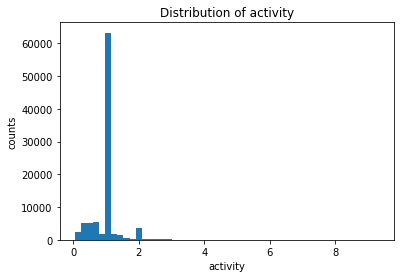

In [32]:
# group the author-centric dataframe by the column, author (suggestion: use seaborn to make plots)
authors_in_conf['publication year'] = authors_in_conf['publication year'].astype(int)
num_paper_per_author_year = (authors_in_conf
                             .groupby('author')
                             .agg({'paper id': 'count', 'publication year': ['max', 'min']})
                             .reset_index()
                             .rename(columns = {'paper id': 'counts'}))
                             
# get rid of redundant double quotes from authors
num_paper_per_author_year['author'] = num_paper_per_author_year['author'].str.strip('\"')

# add a new column indicating the difference between latest year and earliest year
num_paper_per_author_year['diff'] = num_paper_per_author_year['publication year', 'max'] - num_paper_per_author_year['publication year', 'min'] + 1

# add a new column specifying the activity of each author
num_paper_per_author_year['activity'] = num_paper_per_author_year['counts', 'count'] / num_paper_per_author_year['diff']

# show the plot 
plt.hist(num_paper_per_author_year['activity'], bins = 50)
plt.xlabel('activity')
plt.ylabel('counts')
plt.title('Distribution of activity')
plt.show()

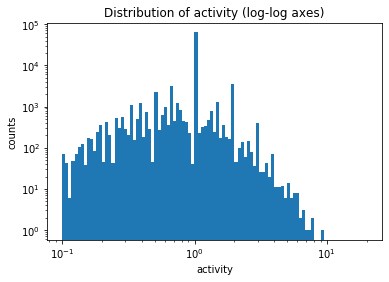

In [33]:
# original activity distribution with log-log axes
plt.hist(num_paper_per_author_year['activity'], bins = np.logspace(np.log10(0.1), np.log10(20), 100))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('activity')
plt.ylabel('counts')
plt.title('Distribution of activity (log-log axes)')
plt.show()

#### Explanation:
1. Since the distribution of authors' activity is heavy-tailed, we also choose to use log-log axes. From the plot, it roughly looks like the log normal distribution.

## Task B. Ranking authors

As you may know, there exist rankings for universities, which represent their relative quality and are used to compare the performance of different universities. In the same vein, there are rankings for conferences and journals, which represent the importance and impact of each conference or journal, and therefore allow for approximate comparisons. In this part, you will rank authors based on different aspects of their research output.

### B1. A Naïve Score

In the absence of citation counts, it is hard to objectively rank the authors based on the impact of their contributions to the field of AI research. A naïve way would be to rank them based on their number of published papers. Obtain such a ranking and analyze your result. Identify and explain some obvious limitations of this scheme.

In [46]:
# construct a dataframe to record the number of papers for each author
author_rank = (authors_in_conf
               .groupby('author')['paper id']
               .count()
               .reset_index()
               .rename(columns = {'paper id': 'papers number'}))

# remove empty value in author column and rank according to number of papers 
author_rank = author_rank[author_rank['author'] != '']
author_rank = author_rank.sort_values(by = 'papers number', ascending = False).reset_index().drop('index', axis = 1)
author_rank['naive rank'] = np.arange(1, author_rank.shape[0]+1)
author_rank.head()

,author,papers number,naive rank
0,Luc Van Gool,196,1
1,Toshio Fukuda,194,2
2,Thomas S. Huang,170,3
3,Michael I. Jordan,152,4
4,Takeo Kanade,148,5


#### Explanation:
**Naive ranking**

*pros*:

\+ Simple to be computed

and *cons*:

\- Ranking based on publication count does not take into account the quality of the conferences. This leads to an over-estimation of authors that publish many papers in low-quality conferences.

\- Old researchers are always advantaged with respect to younger ones (they had more time to publish).

\- Citations are not considered.

\- This kind of ranking does not have good resolution: many authors have published few papers leading to many equal scores in the ranking and such a discrete index makes it difficul to order them.

### B2. H5-index

Another way to score and rank authors could be based on the quality of the conferences and journals where they publish their papers. For this task, you have to use the H5-index score from AMiner (https://aminer.org/ranks/conf) (another database of scholarly publications), which captures the quality of academic conferences: the higher the H5-index, the better the conference.
1. Load the AMiner dataset ( *'aminer_ai.tsv'* available in the folder ``data/``), which contains H5-index values for AI conferences. Load it into a new Pandas dataframe, and join it with the author-centric DBLP dataframe.
2. Calculate a *'new'* author ranking (give each author a score, by which the authors are then sorted in order to obtain the ranking), where each author's score is the sum of the H5-indices of all their papers (the H5-index of a paper being the H5-index of the conference it is published in).
3. Analyze your new, H5-index-based author ranking and explain how and why your results are different from the previous ranking. Do you see any differences in the top-20 authors based on the H5-index-based ranking and the one produced using publication counts? If yes, list the authors that are ranked in the top 20 based on publication counts but absent in the top 20 based on the H5-index-based ranking. Identify the ranks of these authors in the ranking produced by the H5-index based ranking scheme.
4. Now, take the authors in the file `data/list_of_selected_authors.txt`, and compute their rankings using the two (naïve and H5-index-based) ranking schemes. What do you observe? Explain the potential dangers of the naïve, paper-count-based score.
5. On the flip side, do you see any potential dangers of using the H5-index-based score?   
_Hint: Analyze the conferences in which the top ranked authors publish. Investigate the effect of the conferences in which these authors publish more frequently on the obtained ranking._

***B2.1***

#### Load AMiner dataset into a new dataframe and join it with the author-centric dataframe

In [47]:
# Load AMiner dataset
aminer = pd.read_csv('./data/aminer_ai.csv', sep = ';')
aminer.columns = ['rank', 'conference (full name)', 'conference', 'h5-index']
aminer['conference'] = aminer['conference'].str.lower()

# merge author-centric dataframe and aminer dataframe
authors_in_conf_rank = pd.merge(authors_in_conf, aminer)
authors_in_conf_rank.head()

,paper id,publication year,paper title,conference,author,rank,conference (full name),h5-index
0,conf/iccv/KunoOO90,1990,Object recognition using a feature search stra...,iccv,Yoshinori Kuno,6,International Conference on Computer Vision,58
1,conf/iccv/VedulaBRCK99,1999,Three-Dimensional Scene Flow.,iccv,Sundar Vedula,6,International Conference on Computer Vision,58
2,conf/iccv/MeminP99,1999,Fluid Motion Recovery by Coupling Dense and Pa...,iccv,Étienne Mémin,6,International Conference on Computer Vision,58
3,conf/iccv/DickinsonPR90,1990,Qualitative 3-D shape reconstruction using dis...,iccv,Sven J. Dickinson,6,International Conference on Computer Vision,58
4,conf/iccv/SinghYL17,2017,GPLAC: Generalizing Vision-Based Robotic Skill...,iccv,Avi Singh,6,International Conference on Computer Vision,58


***B2.2***

#### Compute each author's total h5-index score and calculate their ranking

In [48]:
# Create a dataframe containing authors' total h5-index score in each conference
author_rank_comp = (authors_in_conf_rank
                    .groupby(['author', 'conference'])['h5-index']
                    .sum()
                    .reset_index()
                    .rename(columns = {'h5-index': 'H5 score'}))

# Group authors in the dataframe and count their total h5-index score 
author_rank_comp = author_rank_comp.groupby('author')['H5 score'].sum().reset_index()
author_rank_comp = author_rank_comp.sort_values(by = 'H5 score', ascending = False).reset_index().drop('index', axis = 1)
author_rank_comp['H5 rank'] = np.arange(1, author_rank_comp.shape[0]+1)
author_rank_comp.head()

,author,H5 score,H5 rank
0,Luc Van Gool,16374,1
1,Thomas S. Huang,13003,2
2,Xiaoou Tang,12546,3
3,Trevor Darrell,11752,4
4,Shuicheng Yan,11333,5


#### Explanation:
**H5 ranking** 

*pros*:

\+ Better resolution than naive score: it is more unlikely that two auhtors have the same exact score.

\+ Quality of the papers is now considered by including the conference relevance.

and *cons*:

\- Old researchers are still advantaged with respect to younger ones (they had more time to publish).

\- Citations are still not considered.

***B2.3***

#### Analyze the h5-index scoring ranking and compare with the one in paper-counting ranking to find any difference

In [49]:
# check the top 20 authors who have more number of papers in both dataframes based on publication counts and h5-index
top_20_naive = author_rank.head(20)
top_20_H5 = author_rank_comp.head(20)
print('Top 20 author rankings base on 2 ranking scheme: \n')
print('Ranking base on paper counts: \n', top_20_naive)
print('\n\nRanking base on H5-index: \n', top_20_H5)

Top 20 author rankings base on 2 ranking scheme: 

Ranking base on paper counts: 
                     author  papers number  naive rank
0             Luc Van Gool            196           1
1            Toshio Fukuda            194           2
2          Thomas S. Huang            170           3
3        Michael I. Jordan            152           4
4             Takeo Kanade            148           5
5           Trevor Darrell            144           6
6              Xiaoou Tang            140           7
7         Vijay Kumar 0001            137           8
8            Shuicheng Yan            133           9
9           Larry S. Davis            131          10
10  Christopher D. Manning            129          11
11          Marc Pollefeys            129          12
12         Roland Siegwart            129          13
13               Dan Klein            128          14
14          Martial Hebert            127          15
15         Wolfram Burgard            125          16

#### Explanation:
1. Apparently, we can see that these two ranking schemes result in different top 20 author lists. For example, Vijay Kumar is one of the top 20 authors in the publication-count ranking system, but he is not in the h5-index scoring ranking system. Therefore, we will check further if there are other authors that are in publication count ranking system but not in h5-index scoring system.

In [50]:
# Find the authors which appear in the naive top 20 but not in the H5 one and show their scores and ranks
only_top_20_naive = top_20_naive[~(top_20_naive['author'].isin(top_20_H5['author']))]
only_top_20_naive = only_top_20_naive.merge(author_rank_comp)
only_top_20_naive

,author,papers number,naive rank,H5 score,H5 rank
0,Michael I. Jordan,152,4,8071,22
1,Vijay Kumar 0001,137,8,8000,23
2,Christopher D. Manning,129,11,5338,62
3,Roland Siegwart,129,13,7675,29
4,Dan Klein,128,14,5073,72
5,Wolfram Burgard,125,16,7161,35
6,Bernhard Schölkopf,123,18,6656,41
7,Gerd Hirzinger,117,19,6779,38
8,Joel W. Burdick,116,20,6699,39


***B2.4***

#### Take the authors from the new text file and compute their ranking base on paper-counting and h5-index scoring scheme

In [51]:
# Load data from text file to a dataframe
authors_from_txt = pd.read_csv('./data/list_of_selected_authors.txt', header = None)
authors_from_txt.columns = {'author'}

# Create a dataframe storing information about specified authors' names, number of papers, and their h5-index scores
temp = author_rank[author_rank['author'].isin(authors_from_txt['author'])]
authors_from_txt = authors_from_txt.merge(temp, how = 'outer', on = 'author')
temp = author_rank_comp[author_rank_comp['author'].isin(authors_from_txt['author'])]
authors_from_txt = authors_from_txt.merge(temp, how = 'outer', on = 'author')
authors_from_txt

,author,papers number,naive rank,H5 score,H5 rank
0,Parag Havaldar,2,29577,170,16426
1,Steffen Abraham,1,40616,112,29149
2,Yukihiro Nakamura,2,25472,170,16552
3,Iljung S. Kwak,2,24101,170,17042
4,Charles Freundlich,2,32040,170,16474
5,Mengjie Zhang,12,3218,132,19376
6,Naokazu Yokoya,11,3628,158,17840
7,Sebastian Otte,7,6402,82,34547
8,Jianwu Dang,4,12596,16,73212
9,Hy Murveit,17,1781,170,16850


In [52]:
# Rank the authors according to the naive method
print('Show the ranking according to paper counting based scheme \n')
authors_from_txt.sort_values(by = 'papers number', ascending = False).reset_index().drop('index', axis = 1)

Show the ranking according to paper counting based scheme 



,author,papers number,naive rank,H5 score,H5 rank
0,Hy Murveit,17,1781,170,16850
1,Mengjie Zhang,12,3218,132,19376
2,Naokazu Yokoya,11,3628,158,17840
3,Sebastian Otte,7,6402,82,34547
4,Jianwu Dang,4,12596,16,73212
5,Parag Havaldar,2,29577,170,16426
6,Yukihiro Nakamura,2,25472,170,16552
7,Iljung S. Kwak,2,24101,170,17042
8,Charles Freundlich,2,32040,170,16474
9,Steffen Abraham,1,40616,112,29149


In [53]:
# Rank the authors base on h5-index scores 
print('Show the ranking according to h5-index based scheme \n')
authors_from_txt.sort_values(by = 'H5 score', ascending = False).reset_index().drop('index', axis = 1)

Show the ranking according to h5-index based scheme 



,author,papers number,naive rank,H5 score,H5 rank
0,Parag Havaldar,2,29577,170,16426
1,Yukihiro Nakamura,2,25472,170,16552
2,Iljung S. Kwak,2,24101,170,17042
3,Charles Freundlich,2,32040,170,16474
4,Hy Murveit,17,1781,170,16850
5,Naokazu Yokoya,11,3628,158,17840
6,Mengjie Zhang,12,3218,132,19376
7,Steffen Abraham,1,40616,112,29149
8,Sebastian Otte,7,6402,82,34547
9,Jianwu Dang,4,12596,16,73212


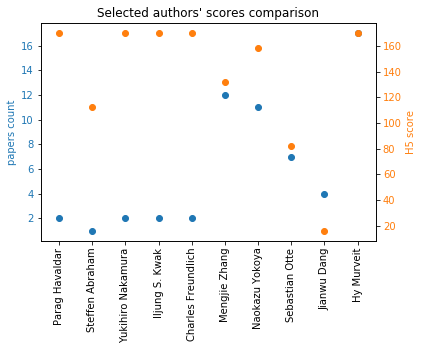

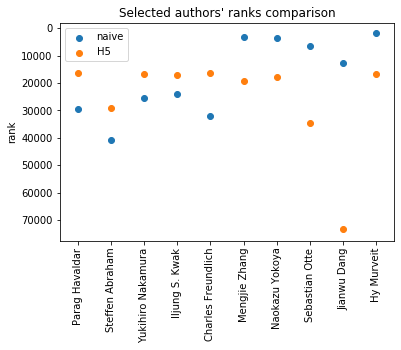

In [85]:
# Graphical comparison of the selected authors' ranks

# Scores comparison
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_ylabel('papers count', color=color)
ax1.scatter(authors_from_txt['author'], authors_from_txt['papers number'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
# plt.ylim([1, 18])
plt.xticks(rotation=90)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('H5 score', color=color)
plt.scatter(authors_from_txt['author'], authors_from_txt['H5 score'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Selected authors' scores comparison")
plt.show()

# Ranks comparison
plt.scatter(authors_from_txt['author'], authors_from_txt['naive rank'])
plt.scatter(authors_from_txt['author'], authors_from_txt['H5 rank'])
plt.xticks(rotation=90)
plt.gca().legend(labels=['naive', 'H5'])
plt.gca().set_ylabel('rank')
plt.gca().invert_yaxis()
plt.title("Selected authors' ranks comparison")
plt.show()

#### Explanation:
In the previous plots we can see how the two rankings does not always agree. 

In the first one we can see the actual scores based on the two criteria (different y scales are used since number of publications and total H5 score are not comparable). Higher dots represent higher scores.

In the second plot (with reversed y axis representing the position in the rank: the highest position is 1) we can compare the positions in the respective rankings. 

***B2.5***

#### Analyze the conferences where the top ranked authors publish and visualize their paper distribution in conferences

In [95]:
# build a pivot table to show the top 20 authors' papers in each conference
num_conf_author = authors_in_conf.groupby(['author', 'conference'])['paper title'].count().reset_index().rename(columns = {'paper title': 'number'})
num_conf_top_author = num_conf_author[num_conf_author['author'].isin((author_rank_comp[:20])['author'].tolist())]
num_conf_top_author_pivot = num_conf_top_author.pivot(index = 'author', columns = 'conference', values = 'number')
num_conf_top_author_pivot.fillna(0, inplace = True)
num_conf_top_author_pivot = num_conf_top_author_pivot.astype(int)
num_conf_top_author_pivot

conference,accv,cvpr,emnlp,fgr,icann,iccv,icml,icra,ijcai,naacl,nips
author,,,,,,,,,,,
Alan L. Yuille,0,53,1,0,0,26,2,1,3,0,26
Andrew Zisserman,11,59,0,5,0,38,0,1,0,0,10
Bernt Schiele,3,64,0,0,0,15,1,2,0,0,5
Cordelia Schmid,0,53,0,0,0,35,0,0,0,0,3
Jitendra Malik,0,56,0,0,0,34,2,3,3,0,9
Katsushi Ikeuchi,12,43,0,1,0,22,0,34,2,0,0
Larry S. Davis,10,65,0,8,0,33,1,8,2,0,4
Luc Van Gool,15,113,0,5,1,46,1,10,0,0,5
Marc Pollefeys,9,66,0,0,0,32,2,18,0,0,2


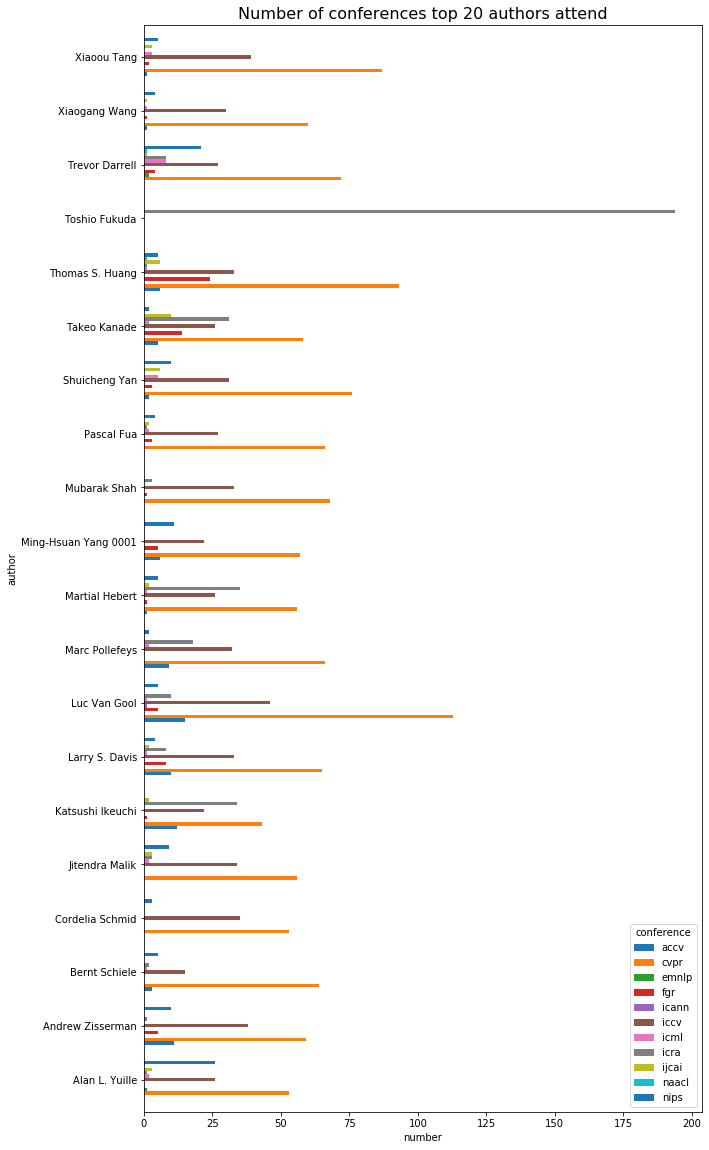

In [96]:
# make a plot to see top 20 authors' publications in various conferences
num_conf_top_author_pivot.plot(kind = 'barh', width = 0.7, figsize = (10, 20), align='center')
plt.tick_params(axis = 'y', which = 'major', labelsize = 10)
plt.xlabel('number', fontsize = 10)
plt.title('Number of conferences top 20 authors attend', fontsize = 16)
plt.show()

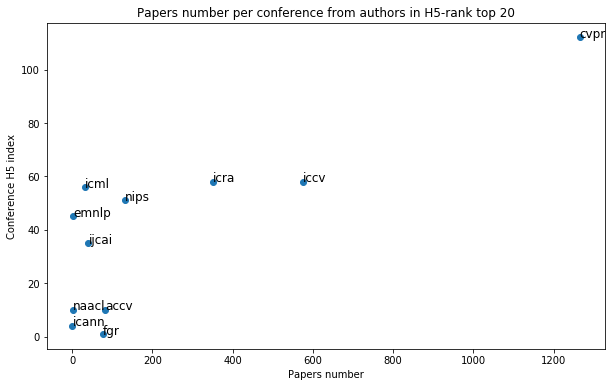

In [66]:
# Identify the most important conference from the point of view of H5-rank
papers_top_20_H5 = authors_in_conf[authors_in_conf['author'].isin(top_20_H5['author'])]
papers_top_20_H5.head()
conferences_top_20_H5 = papers_top_20_H5 \
                       .groupby('conference') \
                       .count() \
                       .rename(columns={'author':'papers number'})['papers number'] \
                       .to_frame()
conferences_top_20_H5 = conferences_top_20_H5.merge(aminer, left_index=True, right_on='conference')

# Scatterplot of papers number per conference from authors in H5-rank top 20
x = conferences_top_20_H5['papers number'].values
y = conferences_top_20_H5['h5-index'].values
code = conferences_top_20_H5['conference'].values
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
for i in range(code.shape[0]):
    plt.annotate(code[i], (x[i], y[i]), size=12)
plt.title('Papers number per conference from authors in H5-rank top 20')
plt.xlabel('Papers number')
plt.ylabel('Conference H5 index')
plt.show()

#### Explanation:
1. From the figure, we can see that these top 20 authors publish their papers more in the conferences which have higher h5-index scores. Specifically, almost every author in the list has more papers published in CVPR, which worths of 112 points in h5 index. As a result, they could obtain more points in h5-index score, improving their ranking. 

### B3. And Justice For All

An ideal ranking scheme should not give undue advantage to authors who have been conducting research for a longer period of time and therefore have naturally published more papers when compared to a junior researcher. Does the ranking scheme designed by you in ``Step 2`` take this factor into account? If not, introduce variations in your ranking scheme to mitigate this effect. Do you observe anything odd with this new ranking? Clearly explain your observations.

_Hint: What you did in part A4 may be useful here._

### Method 1: Average H5-score

In [76]:
# create a temporary dataframe containing information about authors and year difference (max_year - min_year) 
te = num_paper_per_author_year[['author', 'diff']]
te.columns = te.columns.get_level_values(0)
te.head()

,author,diff
0,A Min Tjoa,2
1,A-Yeon Park,1
2,A. A. Clark,1
3,A. A. Jimoh,1
4,A. Afghan,1


In [79]:
# create a new column indicating the average h5-index score for each author
num_paper_per_author_year_h5 = te.merge(author_rank_comp, on = 'author')
num_paper_per_author_year_h5['h5-index avg'] = round(num_paper_per_author_year_h5['H5 score'] / num_paper_per_author_year_h5['diff'], 3)
num_paper_per_author_year_h5.head()

,author,diff,H5 score,H5 rank,h5-index avg
0,A Min Tjoa,2,12,73806,6.0
1,A-Yeon Park,1,1,91143,1.0
2,A. A. Clark,1,112,28811,112.0
3,A. A. Jimoh,1,8,79441,8.0
4,A. Afghan,1,51,58013,51.0


In [81]:
# top 20 authors according to average h5-index score
# (add new metric: (total h5-index score + number of paper * average of h5-index score for each conference involved) / year difference)
num_paper_per_author_year_h5.sort_values(by = 'h5-index avg', ascending = False)[:10]

,author,diff,H5 score,H5 rank,h5-index avg
84608,Xiaoou Tang,15,12546,3,836.400
45869,Li Fei-Fei 0001,3,2198,528,732.667
72156,Shuicheng Yan,17,11333,5,666.647
47170,Luc Van Gool,29,16374,1,564.621
84385,Xiaogang Wang,16,8766,16,547.875
35820,Jiashi Feng,8,4289,118,536.125
84310,Xiaodan Liang,4,2048,596,512.000
73942,Stefanos Zafeiriou,10,4859,86,485.900
64768,Raquel Urtasun,17,7677,28,451.588
49001,Marc Pollefeys,24,10596,7,441.500


#### Explanation:
1. In the new scheme, we not only take total h5-index score into account, but mainly consider  h5-index average. Therefore, from the above dataframe, we can see that some excellent authors could obtain high h5-index scores just by several years. For instance, Li Fei-Fei spent only 3 years to get 2860 points in h5-index score. As a result, we conclude that using h5-index average can be more objective to evaluate authors.

### Method 2: Justice score
While designing a ranking system with the data about authors that we have, we want to equalize all of the factors  - number of papers, H5-score and an activity period. We have designed a scheme combining all of these features: 

$$\textrm{justice_score}_{\textrm{author}} = \frac{{\textrm{publications}}_{\textrm{author}} * \textrm{H5-score}_{\textrm{avg}} + \textrm{H5-score}_{\textrm{author}}}{\textrm{activity}_{\textrm{author}}}$$

We multiply number of author's publications with the average H5-score per paper between the authors (this not only reflex the average H5-score of the conference but considers the number of authors participating on each conferece), add sum author's H5-scores for all papers and divide this with the number of publication years. 


In [82]:
average_h5_score = authors_in_conf_rank["h5-index"].sum() / len(authors_in_conf_rank)
publications_author = authors_in_conf_rank.groupby('author').size().astype('int32')
score_author = authors_in_conf_rank.groupby('author').sum()["h5-index"].astype('int32')
activity_author_end = authors_in_conf_rank.groupby('author')["publication year"].max().astype('int32')
activity_author_start = authors_in_conf_rank.groupby('author')["publication year"].min().astype('int32')

justice_author_rank = (publications_author*average_h5_score + score_author)/(activity_author_end - activity_author_start + 1)

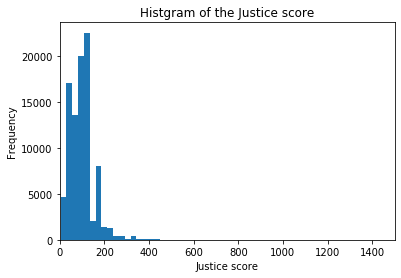

In [83]:
justice_author_rank.sort_values(ascending=False).plot.hist(bins=50, xlim=(0,1500))
plt.title('Histgram of the Justice score')
plt.xlabel('Justice score')
plt.show()

In [84]:
justice_author_rank.sort_values(ascending=False).head(10)

author
Xiaoou Tang           1311.681861
Li Fei-Fei 0001       1123.076767
Shuicheng Yan         1065.045090
Luc Van Gool           908.790313
Jiashi Feng            873.490250
Xiaogang Wang          859.778722
Xiaodan Liang          817.538339
Sergey Levine          793.867984
Stefanos Zafeiriou     781.253728
Raquel Urtasun         736.158257
dtype: float64

In [75]:
tang_papers = len(authors_in_conf_rank[authors_in_conf_rank["author"] == "Xiaoou Tang"])
tang_h5 = authors_in_conf_rank[authors_in_conf_rank["author"] == "Xiaoou Tang"].sum()["h5-index"]
tang_max = authors_in_conf_rank[authors_in_conf_rank["author"] == "Xiaoou Tang"]['publication year'].max()
tang_min = authors_in_conf_rank[authors_in_conf_rank["author"] == "Xiaoou Tang"]['publication year'].min()

print(f"Xiaoou Tang number of papers: {tang_papers}")
print(f"Xiaoou Tang H5-score: {tang_h5}")
print(f"Xiaoou Tang activity start: {tang_min}")
print(f"Xiaoou Tang activity end: {tang_max}")

Xiaoou Tang number of papers: 140
Xiaoou Tang H5-score: 12546
Xiaoou Tang activity start: 2003
Xiaoou Tang activity end: 2017


#### Explanation:
1. The Justice score we have designed could still be improved. Some of the authors which have been active only in short period of time and have large number of papers at the highly ranked conferences would appear still in high ranking. Therefore, we think that active authors are ranked more fairly if we combine H5-score and activity into the evaluation metric. What's more, we could improve the ranking if we have more additional data about the authors. For exapmle, the number of citations or the number of published books. 

## Task C. Trending topics

Historically, the field of AI has witnessed research in two broad flavors: “symbolic” (logic, planning, control, etc.) vs. “connectionist” (neural networks, deep learning, Bayesian methods, etc.). Let’s see if we can see how the popularity of these two approaches to AI is reflected in the DBLP data.

To this end, construct two dataframes: ``symbolic`` and ``connectionist``. ``symbolic`` is your paper-centric dataframe from part A1 filtered down to those papers whose titles contain at least one of the following words (not differentiating between upper and lower case letters): “logic”, “planning”, “control”; ``connectionist`` is a dataframe constructed in a similar manner, but with the words “deep”, “learning”, “feature”, “bayesian”. Plot the number of papers per year for ``symbolic`` and ``connectionist`` separately (i.e., 2 plots).
1. Describe the trends you observe. Based on these plots alone, what might one conclude about the popularity of the two approaches to AI?
2. Moving beyond these plots, what do you, as a careful data scientist, conclude about the popularity of symbolic vs. connectionist AI? Corroborate your reasoning with further plots.

_Note: You could use the text handling utilities below to clean the text in the paper titles._

In [91]:
# Text handling utilities
from string import punctuation
stopwords_list = open('data/stopwords.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])

In [92]:
# remove stopwords and punctuation, lower every character in paper titles as well
paper_title_year = papers_in_conf[['paper title', 'publication year']]
word_list = ((paper_title_year['paper title'].apply(lowercase_all)).apply(remove_punct)).apply(stopword_remover)
word_list.name = 'words'
paper_title_year = pd.concat([paper_title_year, word_list], axis = 1)
paper_title_year.head()

,paper title,publication year,words
paper id,,,
conf/iccv/KunoOO90,Object recognition using a feature search stra...,1990,object recognition using feature search strate...
conf/iccv/VedulaBRCK99,Three-Dimensional Scene Flow.,1999,threedimensional scene flow
conf/iccv/MeminP99,Fluid Motion Recovery by Coupling Dense and Pa...,1999,fluid motion recovery coupling dense parametri...
conf/iccv/DickinsonPR90,Qualitative 3-D shape reconstruction using dis...,1990,qualitative 3d shape reconstruction using dist...
conf/iccv/SinghYL17,GPLAC: Generalizing Vision-Based Robotic Skill...,2017,gplac generalizing visionbased robotic skills ...


In [93]:
# calculate the symbolic count
words_symbolic = ['logic', 'planning', 'control']
pattern = '|'.join(words_symbolic)
symbolic = paper_title_year[['words', 'publication year']]
symbolic['symbolic count'] = (paper_title_year['words'].str.contains(pattern)).astype(int)
symbolic.head()

,words,publication year,symbolic count
paper id,,,
conf/iccv/KunoOO90,object recognition using feature search strate...,1990,0
conf/iccv/VedulaBRCK99,threedimensional scene flow,1999,0
conf/iccv/MeminP99,fluid motion recovery coupling dense parametri...,1999,0
conf/iccv/DickinsonPR90,qualitative 3d shape reconstruction using dist...,1990,0
conf/iccv/SinghYL17,gplac generalizing visionbased robotic skills ...,2017,0


In [94]:
# group them for each year
symbolic_group_year = symbolic.groupby('publication year')['symbolic count'].sum().reset_index()
symbolic_group_year.head()

,publication year,symbolic count
0,1969,5
1,1971,8
2,1973,12
3,1975,14
4,1977,21


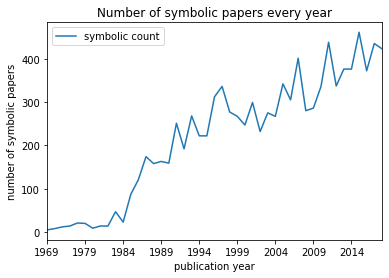

In [95]:
# make a plot
symbolic_group_year.plot(x = 'publication year', y = 'symbolic count')
plt.ylabel('number of symbolic papers')
plt.title('Number of symbolic papers every year')
plt.show()

In [96]:
# calculate connectionist count
words_connectionist = ['deep', 'learning', 'feature', 'bayesian']
pattern = '|'.join(words_connectionist)
connectionist = paper_title_year[['words', 'publication year']]
connectionist['connectionist count'] = (paper_title_year['words'].str.contains(pattern)).astype(int)
connectionist.head()

,words,publication year,connectionist count
paper id,,,
conf/iccv/KunoOO90,object recognition using feature search strate...,1990,1
conf/iccv/VedulaBRCK99,threedimensional scene flow,1999,0
conf/iccv/MeminP99,fluid motion recovery coupling dense parametri...,1999,0
conf/iccv/DickinsonPR90,qualitative 3d shape reconstruction using dist...,1990,0
conf/iccv/SinghYL17,gplac generalizing visionbased robotic skills ...,2017,0


In [97]:
# group them for each year
connectionist_group_year = connectionist.groupby('publication year')['connectionist count'].sum().reset_index()
connectionist_group_year.head()

,publication year,connectionist count
0,1969,4
1,1971,0
2,1973,1
3,1975,7
4,1977,9


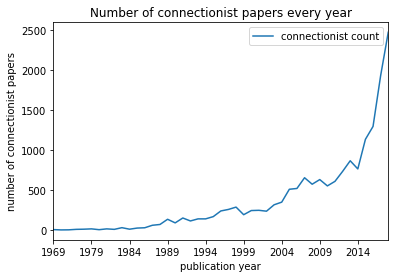

In [98]:
# make a plot
connectionist_group_year.plot(x = 'publication year', y = 'connectionist count')
plt.ylabel('number of connectionist papers')
plt.title('Number of connectionist papers every year')
plt.show()

#### Further analysis

##### Calculate and make annual plots of h5-score and average h5-index of papers categorized in each approach.

In [99]:
# create conference centered dataframe with h5-index
papers_in_conf_h5 = pd.merge(papers_in_conf, aminer)
paper_title_year2 = papers_in_conf_h5[['paper title', 'publication year', 'conference','h5-index']]
word_list2 = ((paper_title_year2['paper title'].apply(lowercase_all)).apply(remove_punct)).apply(stopword_remover)
word_list2.name = 'words2'
paper_title_year2 = pd.concat([paper_title_year2, word_list2], axis = 1)
paper_title_year2.head()

,paper title,publication year,conference,h5-index,words2
0,Object recognition using a feature search stra...,1990,iccv,58,object recognition using feature search strate...
1,Three-Dimensional Scene Flow.,1999,iccv,58,threedimensional scene flow
2,Fluid Motion Recovery by Coupling Dense and Pa...,1999,iccv,58,fluid motion recovery coupling dense parametri...
3,Qualitative 3-D shape reconstruction using dis...,1990,iccv,58,qualitative 3d shape reconstruction using dist...
4,GPLAC: Generalizing Vision-Based Robotic Skill...,2017,iccv,58,gplac generalizing visionbased robotic skills ...


In [100]:
# calculate annual h5-score for symbolic papers
words_symbolic = ['logic', 'planning', 'control']
pattern = '|'.join(words_symbolic)
symbolic2 = paper_title_year2[['words2', 'publication year', 'h5-index','conference']]
symbolic2['symbolic count'] = (paper_title_year2['words2'].str.contains(pattern)).astype(int)
symbolic2['h5_symbolic_count'] = symbolic2['h5-index'] * symbolic2['symbolic count']
symbolic2_sum = symbolic2.groupby('publication year').sum().reset_index()
symbolic2_sum.head()

,publication year,h5-index,symbolic count,h5_symbolic_count
0,1969,2240,5,175
1,1971,2345,8,280
2,1973,3010,12,420
3,1975,5215,14,490
4,1977,8260,21,735


In [101]:
# calculate annual average of h5 value for symbolic papers
symbolic2_mean = symbolic2.groupby('publication year').mean().reset_index()
symbolic2_mean['h5_mean'] = symbolic2_mean['h5_symbolic_count'] / symbolic2_mean['symbolic count']
symbolic2_mean.head()

,publication year,h5-index,symbolic count,h5_symbolic_count,h5_mean
0,1969,35.0,0.078125,2.734375,35.0
1,1971,35.0,0.119403,4.179104,35.0
2,1973,35.0,0.139535,4.883721,35.0
3,1975,35.0,0.093960,3.288591,35.0
4,1977,35.0,0.088983,3.114407,35.0


In [102]:
# calculate annual h5 score for connectioist papers
words_connectionist = ['deep', 'learning', 'feature', 'bayesian']
pattern = '|'.join(words_connectionist)
connectionist2 = paper_title_year2[['words2', 'publication year','h5-index','conference']]
connectionist2['connectionist count'] = (paper_title_year2['words2'].str.contains(pattern)).astype(int)
connectionist2['h5_connectionist_count'] = connectionist2['h5-index'] * connectionist2['connectionist count']
connectionist2_sum = connectionist2.groupby('publication year').sum().reset_index()
connectionist2_sum.head()

,publication year,h5-index,connectionist count,h5_connectionist_count
0,1969,2240,4,140
1,1971,2345,0,0
2,1973,3010,1,35
3,1975,5215,7,245
4,1977,8260,9,315


In [103]:
# calculate annual average of h5-index for connectionist papers
connectionist2_mean = connectionist2.groupby('publication year').mean().reset_index()
connectionist2_mean['h5_mean'] = connectionist2_mean['h5_connectionist_count'] / connectionist2_mean['connectionist count']
connectionist2_mean.head()

,publication year,h5-index,connectionist count,h5_connectionist_count,h5_mean
0,1969,35.0,0.062500,2.187500,35.0
1,1971,35.0,0.000000,0.000000,NaN
2,1973,35.0,0.011628,0.406977,35.0
3,1975,35.0,0.046980,1.644295,35.0
4,1977,35.0,0.038136,1.334746,35.0


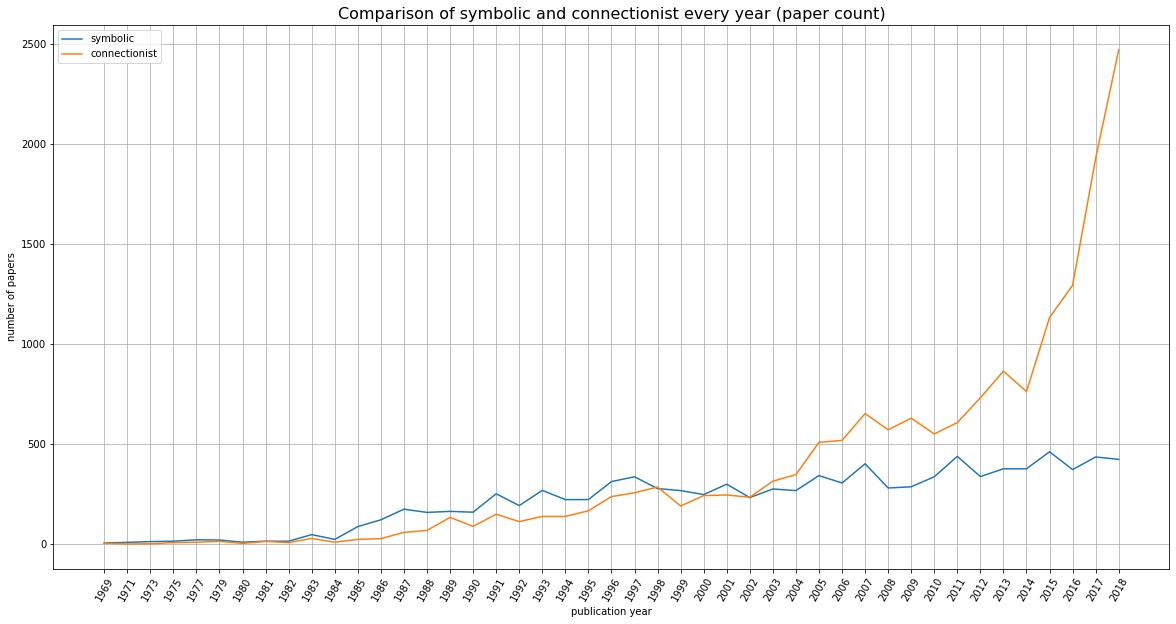

In [104]:
# compare symbolic and connectionists
plt.figure(figsize = (20, 10))
plt.plot(symbolic_group_year['publication year'], symbolic_group_year['symbolic count'], label = 'symbolic')
plt.plot(connectionist_group_year['publication year'], connectionist_group_year['connectionist count'], label = 'connectionist')
plt.xlabel('publication year')
plt.ylabel('number of papers')
plt.title('Comparison of symbolic and connectionist every year (paper count)', fontsize = 16)
plt.xticks(rotation = 60)
plt.grid()
plt.legend()
plt.show()

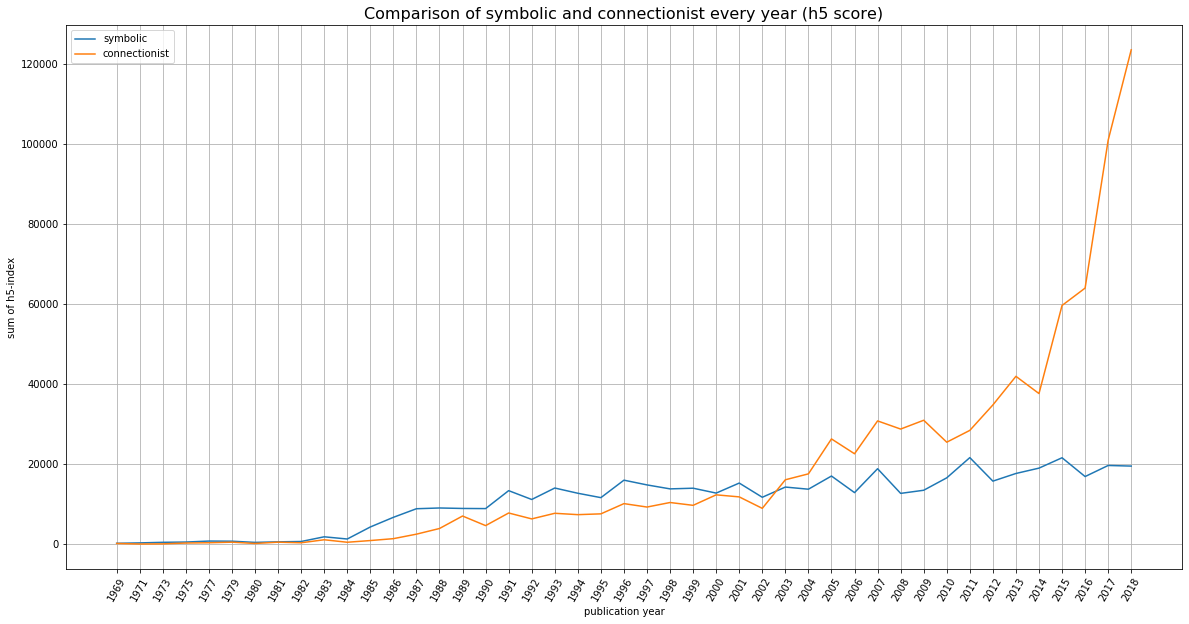

In [106]:
# plot h5-score per year to compare the popularity of symbolic and connectionists
plt.figure(figsize = (20, 10))
plt.plot(symbolic2_sum['publication year'], symbolic2_sum['h5_symbolic_count'], label = 'symbolic')
plt.plot(connectionist2_sum['publication year'], connectionist2_sum['h5_connectionist_count'], label = 'connectionist')
plt.xlabel('publication year')
plt.ylabel('sum of h5-index')
plt.title('Comparison of symbolic and connectionist every year (h5 score)', fontsize = 16)
plt.xticks(rotation = 60)
plt.grid()
plt.legend()
plt.show()

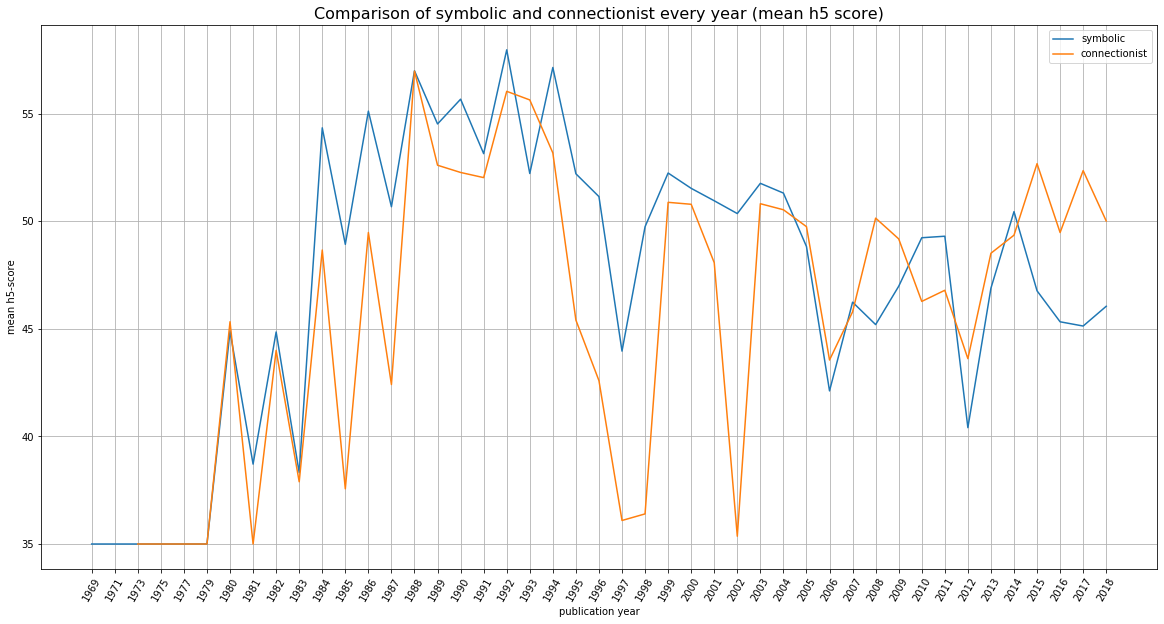

In [108]:
# plot average h5 value per year to compare the popularity of symbolic and connectionists
plt.figure(figsize = (20, 10))
plt.plot(symbolic2_mean['publication year'], symbolic2_mean['h5_mean'], label = 'symbolic')
plt.plot(connectionist2_mean['publication year'], connectionist2_mean['h5_mean'], label = 'connectionist')
plt.xlabel('publication year')
plt.ylabel('mean h5-score')
plt.title('Comparison of symbolic and connectionist every year (mean h5 score)', fontsize = 16)
plt.xticks(rotation = 60)
plt.grid()
plt.legend()
plt.show()

#### Explanation:
1. Both the publication number plot and the h5-score plot show us similar result from which we can see that in the early stage (from 1990s to early 2000s) symbolic AI research dominates, meaning that more papers published at that time. However, in recent years, connectionist AI research overwhelming dominates over symbolic one. In addition, the gap of the number of publications becomes larger and larger by years.

2. Average h5-score plot of symbolic papers is similar to the one of connectionist papers. This means that researcher put more enphasis on connectionist papers and resulting in higher average h5-score than symbolic papers' one.

3. For us, according to the trend from the plot, we predict that connectionist AI research will become more popular than symbolic AI research. To be more specific, the difference between them will be enlarged in future years, making connectionist to be the mainstream of AI research.